# SousChef_3_Predicting Cuisines

**Objective**: Our objective for this notebook is to build a classification model to predict a dish's cuisine based on ingredients. We will train and test our model using the Kaggle dataset that we got from [What's Cooking](https://www.kaggle.com/c/whats-cooking) with ingredients/recipes from Yummly.

We will then use this trained/tested model to predict the cuisines for our SousChef ingredients.

In [2]:
import numpy as np 
import pandas as pd 
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import string
import pickle

import nltk 
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet, stopwords
#from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
from keras.callbacks import History
from sklearn.model_selection import train_test_split


Using TensorFlow backend.
/Users/mariamjaved/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mariamjaved/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mariamjaved/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/mariamjaved/opt/ana

In [2]:
with open('datasets/whats-cooking/train.json', 'r') as f:
    txt = f.read()
df = pd.DataFrame(json.loads(txt))
df.head()

id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...

## EDA

Let's look at how many recipes we have for each cuisine type:

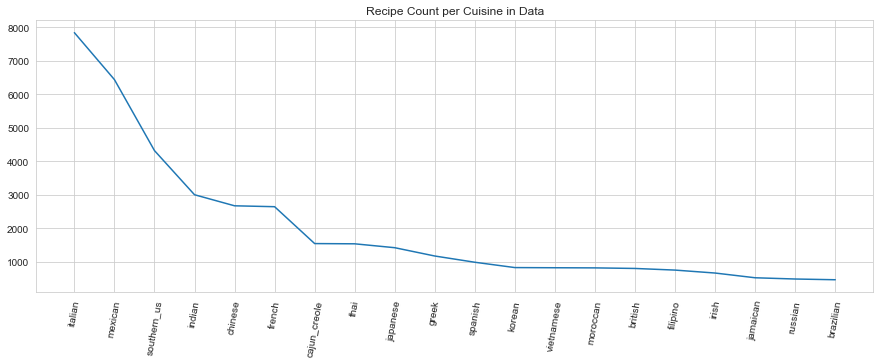

In [3]:
plt.figure(figsize=(15,5))
plt.title('Recipe Count per Cuisine in Data')
ax = df.cuisine.value_counts().plot()
plt.xticks(np.arange(len(df.cuisine.unique())), df.cuisine.value_counts().index, rotation=80)
plt.show()

What ingredients are the most common across all cuisines?

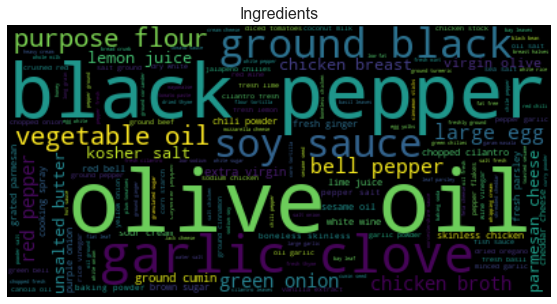

In [4]:
def plot_wordcloud(text, title=None, max = 1000, size=(10,5), title_size=16):
    """plots wordcloud"""
    wordcloud = WordCloud(max_words=max).generate(text)
    plt.figure(figsize=size)
    plt.title(title, size=title_size)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

tok_list = sum([x for x in df.ingredients],[])
tok_list = ' '.join(tok_list)
plot_wordcloud(tok_list, title='Ingredients')

Interesting! The most common ingredients across all cuisines are: olive oil, black pepper, and garlic cloves.

Does any cuisine happen to use a significantly higher/lower number of ingredients than the rest?

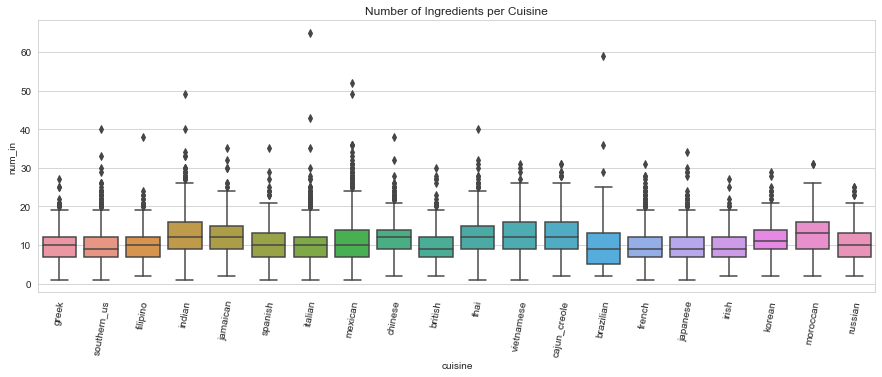

In [5]:
df['num_in'] = df.ingredients.map(lambda x: len(x))
plt.figure(figsize=(15,5))
plt.title('Number of Ingredients per Cuisine')
ax = sns.boxplot(x="cuisine", y="num_in", data=df)
plt.xticks(rotation=80)
plt.show()

What are the most common ingredients for each cuisine? 

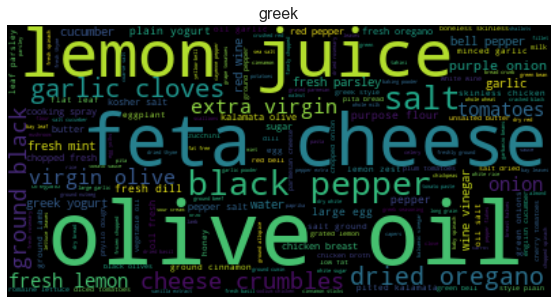

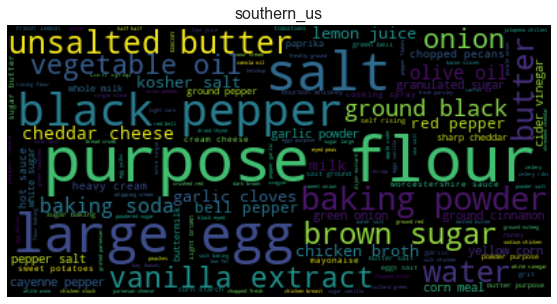

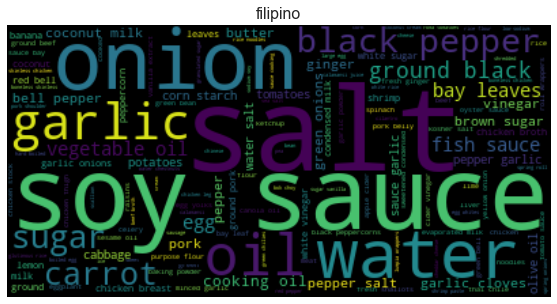

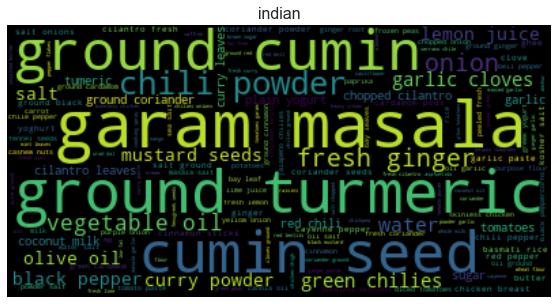

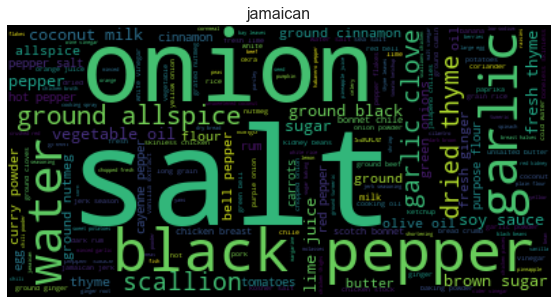

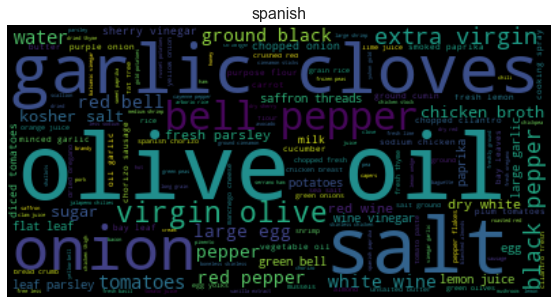

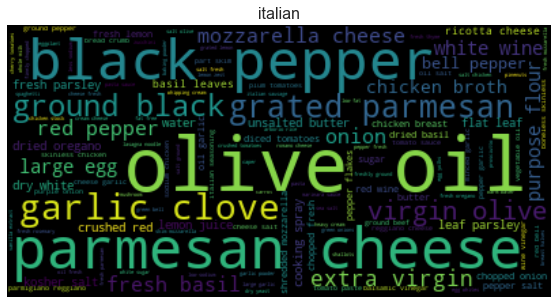

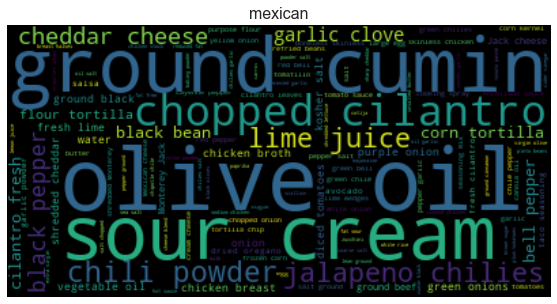

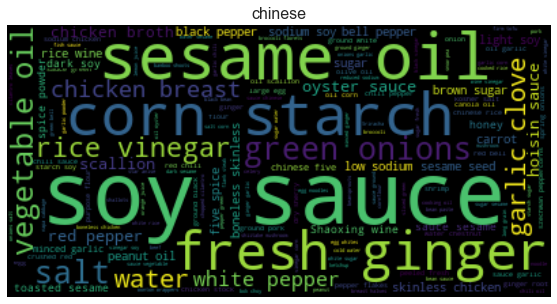

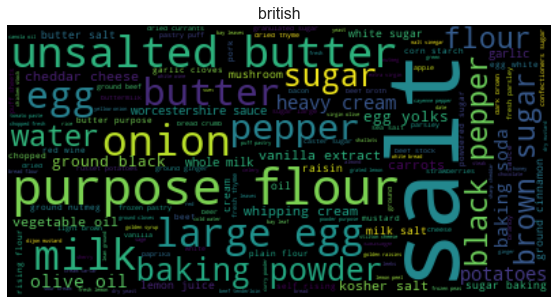

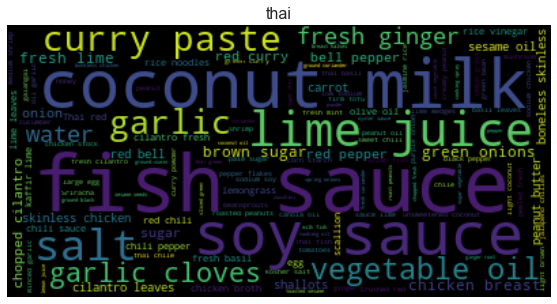

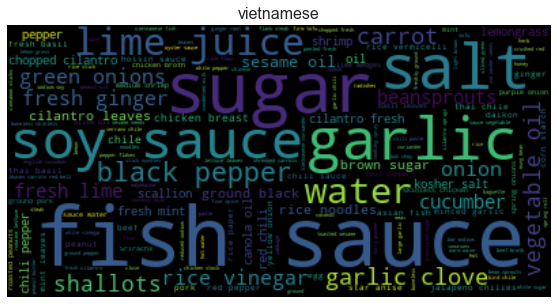

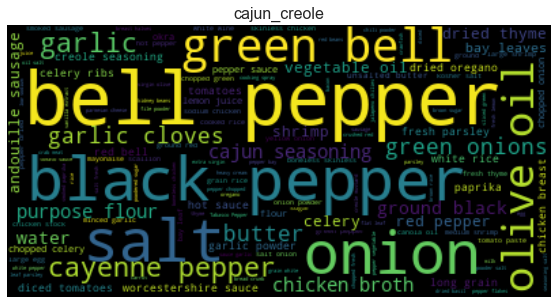

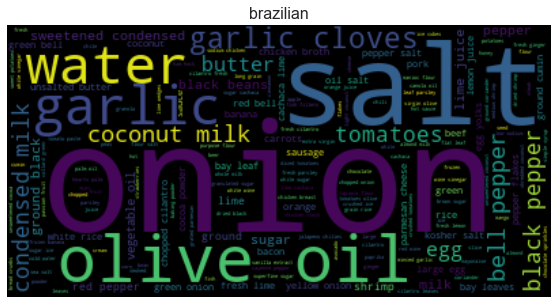

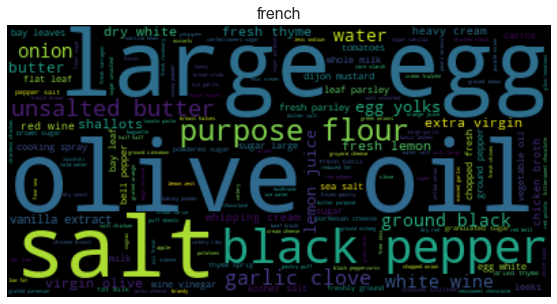

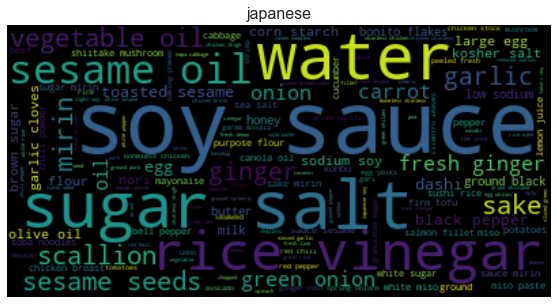

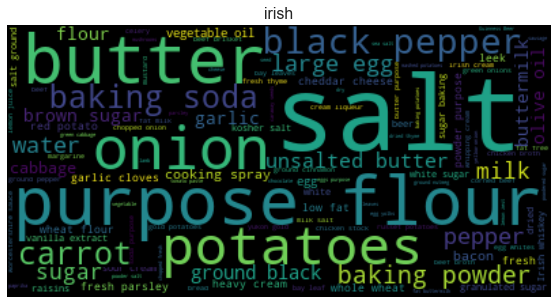

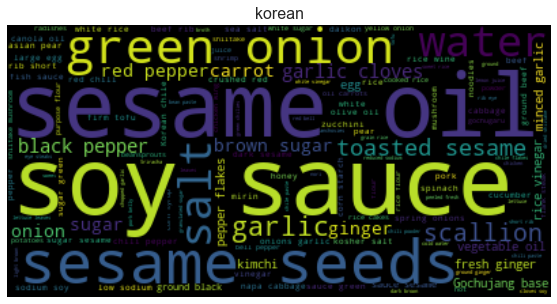

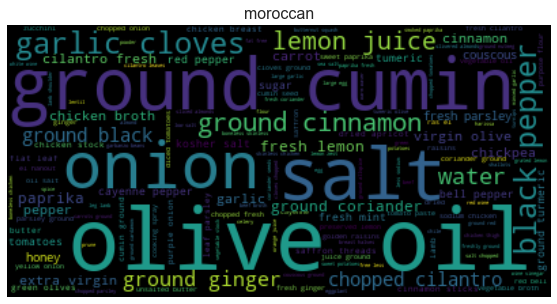

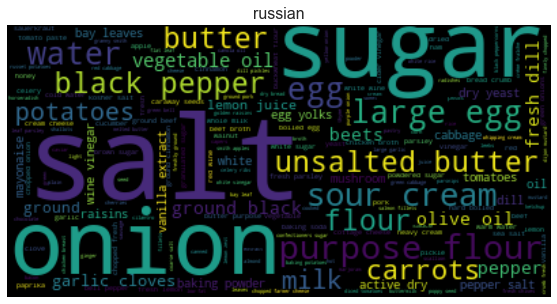

In [6]:
for c in df.cuisine.unique():
    temp = df[df.cuisine == c]
    txt = ' '.join(sum([x for x in temp.ingredients], []))
    plot_wordcloud(txt, title=c)

## Classification Modelling

### Data Preprocessing

In [7]:
#cleaning the data
df['joined'] = df.ingredients.map(lambda x: ' '.join(x))
df_nb = df[['cuisine','joined']]
df_nb.head()

cuisine                                             joined
0        greek  romaine lettuce black olives grape tomatoes ga...
1  southern_us  plain flour ground pepper salt tomatoes ground...
2     filipino  eggs pepper salt mayonaise cooking oil green c...
3       indian                     water vegetable oil wheat salt
4       indian  black pepper shallots cornflour cayenne pepper...

In [8]:
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()
X = count_vect.fit_transform(df_nb.joined)
X = tfidf_transformer.fit_transform(X)
X.shape

(39774, 3010)

### Modelling

#### Logistic Regression:

In [17]:
lr = LogisticRegression()
scores = cross_val_score(lr, X, df_nb.cuisine, cv=5)
print('accuracy CV:',scores)

/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

accuracy CV: [0.77825267 0.78667505 0.77900691 0.78076681 0.78476238]


/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Naive Bayes Multinomial:

In [9]:
clf = MultinomialNB()
scores = cross_val_score(clf, X, df_nb.cuisine, cv=5)
print('accuracy CV:',scores)

accuracy CV: [0.66976744 0.6778127  0.66172219 0.67089881 0.67362333]


#### Random Forest:

In [20]:
rf = RandomForestClassifier()
scores = cross_val_score(rf, X, df.cuisine, cv=5)
print('accuracy CV:',scores)

accuracy CV: [0.745066   0.75487115 0.74632307 0.73890635 0.74993714]


#### Support Vector Machines:

In [23]:
svm = SVC()
scores = cross_val_score(svm, X, df.cuisine, cv=5)
print('accuracy CV:',scores)

accuracy CV: [0.79899434 0.80502828 0.79874293 0.79371464 0.80374654]


#### Neural Network:

In [24]:
def simple_NN(input_shape, nodes_per=[128], hidden=3, out=2, act_out='softmax', act_hid='relu', drop=True, d_rate=0.5):
    model = Sequential()
    #adding first hidden layer with 60 nodes (first value in nodes_per list)
    model.add(Dense(nodes_per[0],activation=act_hid,input_shape=input_shape))
    
    if drop:
        model.add(Dropout(d_rate))
        
    try:
        if hidden != 0:
            for i,j in zip(range(hidden), nodes_per[1:]):
                model.add(Dense(j,activation=act_hid))
                if drop:
                    model.add(Dropout(d_rate))
        model.add(Dense(out,activation=act_out))
        return(model)
    except:
        print('Error in generating hidden layers')

ch_dict = dict([(y,x) for x,y in enumerate(set(df_nb.cuisine))])
y = np.array([ch_dict[x] for x in df_nb.cuisine])
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print('creating and training model...')
model = simple_NN(input_shape=(X.shape[1],), hidden=5, out=y.shape[1], drop=True)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])
early_stopping_monitor = EarlyStopping(patience=3)
history = model.fit(X_train,y_train, epochs=1000, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor], verbose=True)
print('model trained')

creating and training model...
Train on 35796 samples, validate on 3978 samples
Epoch 1/1000
35796/35796 [==============================] - 18s 512us/step - loss: 1.4007 - acc: 0.6178 - val_loss: 0.8700 - val_acc: 0.7471
Epoch 2/1000
35796/35796 [==============================] - 16s 437us/step - loss: 0.8489 - acc: 0.7561 - val_loss: 0.7371 - val_acc: 0.7800
Epoch 3/1000
35796/35796 [==============================] - 16s 436us/step - loss: 0.7272 - acc: 0.7862 - val_loss: 0.6911 - val_acc: 0.7924
Epoch 4/1000
35796/35796 [==============================] - 18s 491us/step - loss: 0.6608 - acc: 0.8033 - val_loss: 0.6751 - val_acc: 0.7966
Epoch 5/1000
35796/35796 [==============================] - 16s 458us/step - loss: 0.6188 - acc: 0.8139 - val_loss: 0.6668 - val_acc: 0.7996
Epoch 6/1000
35796/35796 [==============================] - 17s 473us/step - loss: 0.5828 - acc: 0.8248 - val_loss: 0.6682 - val_acc: 0.8024
Epoch 7/1000
35796/35796 [==============================] - 16s 444us/step

We see train and test accuracy of 0.85 and 0.80 - which is really good. A little overfit still, but this is the best result we've seen.

In [25]:
#save model
from sklearn.externals import joblib

joblib.dump(model, 'cuisine_class_att1.pkl')

['cuisine_class_att1.pkl']

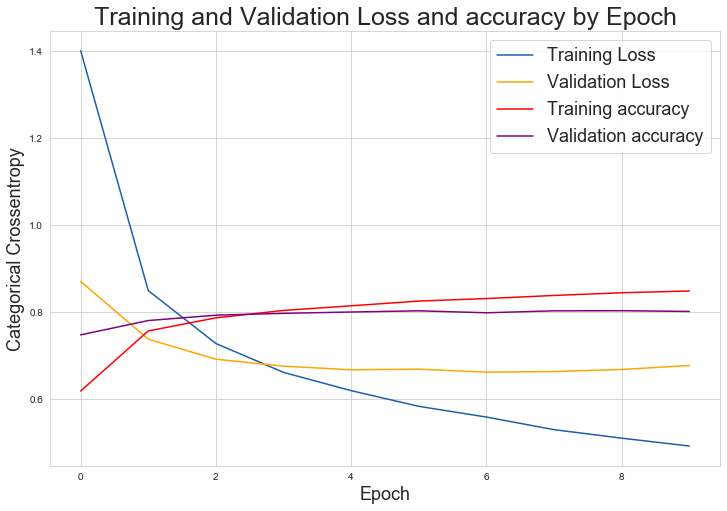

In [26]:
# Check out our train loss and test loss over epochs.

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

# Set figure size

plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs

plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(val_loss, label='Validation Loss', color='orange')

# Generate line plot of training, testing loss over epochs

plt.plot(train_accuracy, label='Training accuracy', color='red')
plt.plot(val_accuracy, label='Validation accuracy', color='purple')

# Set title

plt.title('Training and Validation Loss and accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

Neural Network Testing Model:

In [27]:
with open('datasets/whats-cooking/test.json', 'r') as f:
    txt = f.read()
    
df_test = pd.DataFrame(json.loads(txt))

In [28]:
df_test.head()

id                                        ingredients
0  18009  [baking powder, eggs, all-purpose flour, raisi...
1  28583  [sugar, egg yolks, corn starch, cream of tarta...
2  41580  [sausage links, fennel bulb, fronds, olive oil...
3  29752  [meat cuts, file powder, smoked sausage, okra,...
4  35687  [ground black pepper, salt, sausage casings, l...

In [29]:
#strings
df_test['joined'] = df_test.ingredients.map(lambda x: ' '.join(x))

In [30]:
df_test.head()

id                                        ingredients  \
0  18009  [baking powder, eggs, all-purpose flour, raisi...   
1  28583  [sugar, egg yolks, corn starch, cream of tarta...   
2  41580  [sausage links, fennel bulb, fronds, olive oil...   
3  29752  [meat cuts, file powder, smoked sausage, okra,...   
4  35687  [ground black pepper, salt, sausage casings, l...   

                                              joined  
0  baking powder eggs all-purpose flour raisins m...  
1  sugar egg yolks corn starch cream of tartar ba...  
2  sausage links fennel bulb fronds olive oil cub...  
3  meat cuts file powder smoked sausage okra shri...  
4  ground black pepper salt sausage casings leeks...

In [31]:
df_test = df_test.drop(['ingredients'], axis=1)
df_test.head()

id                                             joined
0  18009  baking powder eggs all-purpose flour raisins m...
1  28583  sugar egg yolks corn starch cream of tartar ba...
2  41580  sausage links fennel bulb fronds olive oil cub...
3  29752  meat cuts file powder smoked sausage okra shri...
4  35687  ground black pepper salt sausage casings leeks...

In [32]:
dec_dict = dict([(x,y) for y,x in ch_dict.items()])

X_test = np.array(df_test.joined)
X_test = count_vect.transform(X_test)
X_test = tfidf_transformer.transform(X_test)

In [33]:
preds = model.predict(X_test)
y_test = [dec_dict[np.argmax(x)] for x in preds]
df_test['cuisine'] = y_test
df_test.head()

id                                             joined       cuisine
0  18009  baking powder eggs all-purpose flour raisins m...       british
1  28583  sugar egg yolks corn starch cream of tartar ba...   southern_us
2  41580  sausage links fennel bulb fronds olive oil cub...       italian
3  29752  meat cuts file powder smoked sausage okra shri...  cajun_creole
4  35687  ground black pepper salt sausage casings leeks...       italian

## Predict Cuisines for SousChef

Let's now apply the NN model to our SousChef dataset to predict the cuisine type.

Clean data:

In [34]:
df_sc = pd.read_csv('datasets/recipes_topic_modelled.csv')
df_sc.head()

title  time  \
0               Mexican Caviar   370   
1  Air Fryer Stuffed Mushrooms    35   
2      Everything Deviled Eggs    35   
3   Easy Rumaki with Pineapple    40   
4       Fried Mozzarella Puffs   100   

                                         ingredients  \
0  ['2 large tomatoes, finely chopped', '5 green ...   
1  ['1 (16 ounce) package whole white button mush...   
2  ['6 large eggs', '2 tablespoons full-fat plain...   
3  ['cooking spray', '24 (1 inch) cubes fresh pin...   
4  ['⅓ cup water', '2 tablespoons unsalted butter...   

                                        instructions  \
0  In a medium bowl, mix together tomatoes, green...   
1  Using a damp cloth, gently clean mushrooms. Re...   
2  Place eggs in a saucepan and cover with water....   
3  Preheat oven to 375 degrees F (190 degrees C)....   
4  Combine water, butter, and salt in a saucepan ...   

                                           title_ing  \
0  Mexican Caviar     large tomatoes  finely chop...   
1  Air Fryer Stuffed Mushrooms         ounce  pac...   
2  Everything Deviled Eggs     large eggs      ta...   
3  Easy Rumaki with Pineapple   cooking spray    ...   
4  Fried Mozzarella Puffs     cup water      tabl...   

                                         all_recipes  subCat    mainCat  
0  ['mexican', 'caviar', 'tomato', 'finely', 'gre...       2   maindish  
1  ['air', 'fryer', 'stuffed', 'mushroom', 'packa...       3   maindish  
2  ['everything', 'deviled', 'egg', 'egg', 'full'...      18   maindish  
3  ['easy', 'rumaki', 'pineapple', 'cooking', 'sp...      17  breakfast  
4  ['fried', 'mozzarella', 'puff', 'water', 'unsa...       2   maindish

In [35]:
df = df_sc.drop(['subCat', 'all_recipes'], axis = 1)
df.head()

title  time  \
0               Mexican Caviar   370   
1  Air Fryer Stuffed Mushrooms    35   
2      Everything Deviled Eggs    35   
3   Easy Rumaki with Pineapple    40   
4       Fried Mozzarella Puffs   100   

                                         ingredients  \
0  ['2 large tomatoes, finely chopped', '5 green ...   
1  ['1 (16 ounce) package whole white button mush...   
2  ['6 large eggs', '2 tablespoons full-fat plain...   
3  ['cooking spray', '24 (1 inch) cubes fresh pin...   
4  ['⅓ cup water', '2 tablespoons unsalted butter...   

                                        instructions  \
0  In a medium bowl, mix together tomatoes, green...   
1  Using a damp cloth, gently clean mushrooms. Re...   
2  Place eggs in a saucepan and cover with water....   
3  Preheat oven to 375 degrees F (190 degrees C)....   
4  Combine water, butter, and salt in a saucepan ...   

                                           title_ing    mainCat  
0  Mexican Caviar     large tomatoes  finely chop...   maindish  
1  Air Fryer Stuffed Mushrooms         ounce  pac...   maindish  
2  Everything Deviled Eggs     large eggs      ta...   maindish  
3  Easy Rumaki with Pineapple   cooking spray    ...  breakfast  
4  Fried Mozzarella Puffs     cup water      tabl...   maindish

In [36]:
df.columns

Index(['title', 'time', 'ingredients', 'instructions', 'title_ing', 'mainCat'], dtype='object')

In [37]:
df.columns = ['title', 'time', 'ingredients', 'instructions', 'title_ing','meal_type']
df.head()

title  time  \
0               Mexican Caviar   370   
1  Air Fryer Stuffed Mushrooms    35   
2      Everything Deviled Eggs    35   
3   Easy Rumaki with Pineapple    40   
4       Fried Mozzarella Puffs   100   

                                         ingredients  \
0  ['2 large tomatoes, finely chopped', '5 green ...   
1  ['1 (16 ounce) package whole white button mush...   
2  ['6 large eggs', '2 tablespoons full-fat plain...   
3  ['cooking spray', '24 (1 inch) cubes fresh pin...   
4  ['⅓ cup water', '2 tablespoons unsalted butter...   

                                        instructions  \
0  In a medium bowl, mix together tomatoes, green...   
1  Using a damp cloth, gently clean mushrooms. Re...   
2  Place eggs in a saucepan and cover with water....   
3  Preheat oven to 375 degrees F (190 degrees C)....   
4  Combine water, butter, and salt in a saucepan ...   

                                           title_ing  meal_type  
0  Mexican Caviar     large tomatoes  finely chop...   maindish  
1  Air Fryer Stuffed Mushrooms         ounce  pac...   maindish  
2  Everything Deviled Eggs     large eggs      ta...   maindish  
3  Easy Rumaki with Pineapple   cooking spray    ...  breakfast  
4  Fried Mozzarella Puffs     cup water      tabl...   maindish

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5039 entries, 0 to 5038
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         5039 non-null   object
 1   time          5039 non-null   int64 
 2   ingredients   5039 non-null   object
 3   instructions  5039 non-null   object
 4   title_ing     5039 non-null   object
 5   meal_type     5039 non-null   object
dtypes: int64(1), object(5)
memory usage: 236.3+ KB


In [39]:
from nltk.stem import WordNetLemmatizer

#Source for list below
#https://en.wikipedia.org/wiki/Cooking_weights_and_measures
#https://thebakingpan.com/ingredient-weights-and-measures/
measures=['litres','liter','millilitres','millilitre','mL','grams','g', 'kg',
          'teaspoon','tsp', 'tablespoon','tbsp','fluid', 'ounce',
          'oz','fl.oz', 'cup','pint','pt','quart','qt','gallon','gal',
          'smidgen','drop','pinch','dash','scruple','dessertspoon','teacup',
          'cup','c','pottle','gill','dram','wineglass','coffeespoon','pound',
          'lb','tbsp','plus','firmly', 'packed','lightly','level','even',
          'rounded','heaping','heaped','sifted','bushel','peck','stick',
          'chopped','sliced','halves', 'shredded','slivered','sliced',
          'whole','paste','whole',' fresh', 'peeled', 'diced','mashed',
          'dried','frozen','fresh','peeled','candied','no', 'pulp',
          'crystallized','canned','crushed','minced','julienned','clove',
          'head', 'small','large','medium']

lemmatizer = WordNetLemmatizer()

measures = [lemmatizer.lemmatize(m) for m in measures]

In [40]:
from nltk.corpus import stopwords
import string

recipes = []
ingredients = []
bi_ingredients = []

def parse_recipes(df, column):
    ingr_list = []
    
    stop_words = stopwords.words('english')
    
    for docs in (df[column]):
        #translates each doc
        docs.translate(str.maketrans('', '', string.punctuation))
        #splits docs on the spaces
        words=docs.split()
        #ensures all punctuation is removed
        words = [''.join(c for c in word if c not in string.punctuation) for word in words]
        #ensures that no numbers are leftover and that it's only words
        words = [word for word in words if word.isalpha()]
        #lowercase
        words = [word.lower() for word in words]
        #lemmatizes words
        words = [lemmatizer.lemmatize(word) for word in words]
        #removes all weights/measuring words
        words = [word for word in words if word not in measures]
        #removes all stopwords
        words = [word for word in words if word not in stop_words]
        
        #df[column][docs] = words
        ingr_list.append(words)
    
        bigrm = list(nltk.bigrams(words))
        bi_ingredients.append(bigrm)
        
        for word in words:
            ingredients.append(word)
    recipes.append(ingr_list)

In [41]:
parse_recipes(df, 'title_ing')

In [42]:
all_recipes = [] 

for recipe in recipes:
    for x in recipe:
        all_recipes.append(x)

In [43]:
df['all_recipes'] = all_recipes

In [44]:
df.head()

title  time  \
0               Mexican Caviar   370   
1  Air Fryer Stuffed Mushrooms    35   
2      Everything Deviled Eggs    35   
3   Easy Rumaki with Pineapple    40   
4       Fried Mozzarella Puffs   100   

                                         ingredients  \
0  ['2 large tomatoes, finely chopped', '5 green ...   
1  ['1 (16 ounce) package whole white button mush...   
2  ['6 large eggs', '2 tablespoons full-fat plain...   
3  ['cooking spray', '24 (1 inch) cubes fresh pin...   
4  ['⅓ cup water', '2 tablespoons unsalted butter...   

                                        instructions  \
0  In a medium bowl, mix together tomatoes, green...   
1  Using a damp cloth, gently clean mushrooms. Re...   
2  Place eggs in a saucepan and cover with water....   
3  Preheat oven to 375 degrees F (190 degrees C)....   
4  Combine water, butter, and salt in a saucepan ...   

                                           title_ing  meal_type  \
0  Mexican Caviar     large tomatoes  finely chop...   maindish   
1  Air Fryer Stuffed Mushrooms         ounce  pac...   maindish   
2  Everything Deviled Eggs     large eggs      ta...   maindish   
3  Easy Rumaki with Pineapple   cooking spray    ...  breakfast   
4  Fried Mozzarella Puffs     cup water      tabl...   maindish   

                                         all_recipes  
0  [mexican, caviar, tomato, finely, green, onion...  
1  [air, fryer, stuffed, mushroom, package, white...  
2  [everything, deviled, egg, egg, full, fat, pla...  
3  [easy, rumaki, pineapple, cooking, spray, inch...  
4  [fried, mozzarella, puff, water, unsalted, but...

In [45]:
#move columns around
df = df[['title', 'time', 'meal_type', 'instructions', 'ingredients','title_ing', 'all_recipes']]
df.head()

title  time  meal_type  \
0               Mexican Caviar   370   maindish   
1  Air Fryer Stuffed Mushrooms    35   maindish   
2      Everything Deviled Eggs    35   maindish   
3   Easy Rumaki with Pineapple    40  breakfast   
4       Fried Mozzarella Puffs   100   maindish   

                                        instructions  \
0  In a medium bowl, mix together tomatoes, green...   
1  Using a damp cloth, gently clean mushrooms. Re...   
2  Place eggs in a saucepan and cover with water....   
3  Preheat oven to 375 degrees F (190 degrees C)....   
4  Combine water, butter, and salt in a saucepan ...   

                                         ingredients  \
0  ['2 large tomatoes, finely chopped', '5 green ...   
1  ['1 (16 ounce) package whole white button mush...   
2  ['6 large eggs', '2 tablespoons full-fat plain...   
3  ['cooking spray', '24 (1 inch) cubes fresh pin...   
4  ['⅓ cup water', '2 tablespoons unsalted butter...   

                                           title_ing  \
0  Mexican Caviar     large tomatoes  finely chop...   
1  Air Fryer Stuffed Mushrooms         ounce  pac...   
2  Everything Deviled Eggs     large eggs      ta...   
3  Easy Rumaki with Pineapple   cooking spray    ...   
4  Fried Mozzarella Puffs     cup water      tabl...   

                                         all_recipes  
0  [mexican, caviar, tomato, finely, green, onion...  
1  [air, fryer, stuffed, mushroom, package, white...  
2  [everything, deviled, egg, egg, full, fat, pla...  
3  [easy, rumaki, pineapple, cooking, spray, inch...  
4  [fried, mozzarella, puff, water, unsalted, but...

In [46]:
df.columns = ['title', 'time', 'meal_type', 'instructions', 'ingredients', 'title_ing_joined', 'formatted_text']
df.head()

title  time  meal_type  \
0               Mexican Caviar   370   maindish   
1  Air Fryer Stuffed Mushrooms    35   maindish   
2      Everything Deviled Eggs    35   maindish   
3   Easy Rumaki with Pineapple    40  breakfast   
4       Fried Mozzarella Puffs   100   maindish   

                                        instructions  \
0  In a medium bowl, mix together tomatoes, green...   
1  Using a damp cloth, gently clean mushrooms. Re...   
2  Place eggs in a saucepan and cover with water....   
3  Preheat oven to 375 degrees F (190 degrees C)....   
4  Combine water, butter, and salt in a saucepan ...   

                                         ingredients  \
0  ['2 large tomatoes, finely chopped', '5 green ...   
1  ['1 (16 ounce) package whole white button mush...   
2  ['6 large eggs', '2 tablespoons full-fat plain...   
3  ['cooking spray', '24 (1 inch) cubes fresh pin...   
4  ['⅓ cup water', '2 tablespoons unsalted butter...   

                                    title_ing_joined  \
0  Mexican Caviar     large tomatoes  finely chop...   
1  Air Fryer Stuffed Mushrooms         ounce  pac...   
2  Everything Deviled Eggs     large eggs      ta...   
3  Easy Rumaki with Pineapple   cooking spray    ...   
4  Fried Mozzarella Puffs     cup water      tabl...   

                                      formatted_text  
0  [mexican, caviar, tomato, finely, green, onion...  
1  [air, fryer, stuffed, mushroom, package, white...  
2  [everything, deviled, egg, egg, full, fat, pla...  
3  [easy, rumaki, pineapple, cooking, spray, inch...  
4  [fried, mozzarella, puff, water, unsalted, but...

In [47]:
df['joined'] = df.formatted_text.map(lambda x: ' '.join(x))
df.head()

title  time  meal_type  \
0               Mexican Caviar   370   maindish   
1  Air Fryer Stuffed Mushrooms    35   maindish   
2      Everything Deviled Eggs    35   maindish   
3   Easy Rumaki with Pineapple    40  breakfast   
4       Fried Mozzarella Puffs   100   maindish   

                                        instructions  \
0  In a medium bowl, mix together tomatoes, green...   
1  Using a damp cloth, gently clean mushrooms. Re...   
2  Place eggs in a saucepan and cover with water....   
3  Preheat oven to 375 degrees F (190 degrees C)....   
4  Combine water, butter, and salt in a saucepan ...   

                                         ingredients  \
0  ['2 large tomatoes, finely chopped', '5 green ...   
1  ['1 (16 ounce) package whole white button mush...   
2  ['6 large eggs', '2 tablespoons full-fat plain...   
3  ['cooking spray', '24 (1 inch) cubes fresh pin...   
4  ['⅓ cup water', '2 tablespoons unsalted butter...   

                                    title_ing_joined  \
0  Mexican Caviar     large tomatoes  finely chop...   
1  Air Fryer Stuffed Mushrooms         ounce  pac...   
2  Everything Deviled Eggs     large eggs      ta...   
3  Easy Rumaki with Pineapple   cooking spray    ...   
4  Fried Mozzarella Puffs     cup water      tabl...   

                                      formatted_text  \
0  [mexican, caviar, tomato, finely, green, onion...   
1  [air, fryer, stuffed, mushroom, package, white...   
2  [everything, deviled, egg, egg, full, fat, pla...   
3  [easy, rumaki, pineapple, cooking, spray, inch...   
4  [fried, mozzarella, puff, water, unsalted, but...   

                                              joined  
0  mexican caviar tomato finely green onion olive...  
1  air fryer stuffed mushroom package white butto...  
2  everything deviled egg egg full fat plain gree...  
3  easy rumaki pineapple cooking spray inch cube ...  
4  fried mozzarella puff water unsalted butter ko...

Let's now run our developed model on our sous_chef dataframe to predict cuisine types for the ingredients:

In [48]:
dec_dict = dict([(x,y) for y,x in ch_dict.items()])

X_sc = np.array(df.joined)
X_sc = count_vect.transform(X_sc)
X_sc = tfidf_transformer.transform(X_sc)

In [49]:
preds = model.predict(X_sc)
y_sc = [dec_dict[np.argmax(x)] for x in preds]
df['cuisine'] = y_sc
df.head()

title  time  meal_type  \
0               Mexican Caviar   370   maindish   
1  Air Fryer Stuffed Mushrooms    35   maindish   
2      Everything Deviled Eggs    35   maindish   
3   Easy Rumaki with Pineapple    40  breakfast   
4       Fried Mozzarella Puffs   100   maindish   

                                        instructions  \
0  In a medium bowl, mix together tomatoes, green...   
1  Using a damp cloth, gently clean mushrooms. Re...   
2  Place eggs in a saucepan and cover with water....   
3  Preheat oven to 375 degrees F (190 degrees C)....   
4  Combine water, butter, and salt in a saucepan ...   

                                         ingredients  \
0  ['2 large tomatoes, finely chopped', '5 green ...   
1  ['1 (16 ounce) package whole white button mush...   
2  ['6 large eggs', '2 tablespoons full-fat plain...   
3  ['cooking spray', '24 (1 inch) cubes fresh pin...   
4  ['⅓ cup water', '2 tablespoons unsalted butter...   

                                    title_ing_joined  \
0  Mexican Caviar     large tomatoes  finely chop...   
1  Air Fryer Stuffed Mushrooms         ounce  pac...   
2  Everything Deviled Eggs     large eggs      ta...   
3  Easy Rumaki with Pineapple   cooking spray    ...   
4  Fried Mozzarella Puffs     cup water      tabl...   

                                      formatted_text  \
0  [mexican, caviar, tomato, finely, green, onion...   
1  [air, fryer, stuffed, mushroom, package, white...   
2  [everything, deviled, egg, egg, full, fat, pla...   
3  [easy, rumaki, pineapple, cooking, spray, inch...   
4  [fried, mozzarella, puff, water, unsalted, but...   

                                              joined      cuisine  
0  mexican caviar tomato finely green onion olive...      mexican  
1  air fryer stuffed mushroom package white butto...  southern_us  
2  everything deviled egg egg full fat plain gree...      british  
3  easy rumaki pineapple cooking spray inch cube ...      chinese  
4  fried mozzarella puff water unsalted butter ko...      italian

In [50]:
df.cuisine.value_counts()

southern_us     1997
italian          862
mexican          729
french           389
british          178
irish            148
chinese          105
japanese         102
filipino          90
indian            74
cajun_creole      72
greek             72
russian           58
spanish           34
jamaican          31
thai              25
korean            22
vietnamese        21
brazilian         18
moroccan          12
Name: cuisine, dtype: int64

Our cuisine predictions are...not bad at all! They seem to make sense are quite accurate.

In [51]:
#save new df
df.to_csv('datasets/final_recipes.csv', index = False)

Let's also look at the frequency of cuisine within our SousChef recipe dataset - we see here that Southern_US, Italian, and Mexican have the highest frequency of recipes and moroccon, brazilian, vietnamese etc. all have the lowest frequency count of within the recipes.

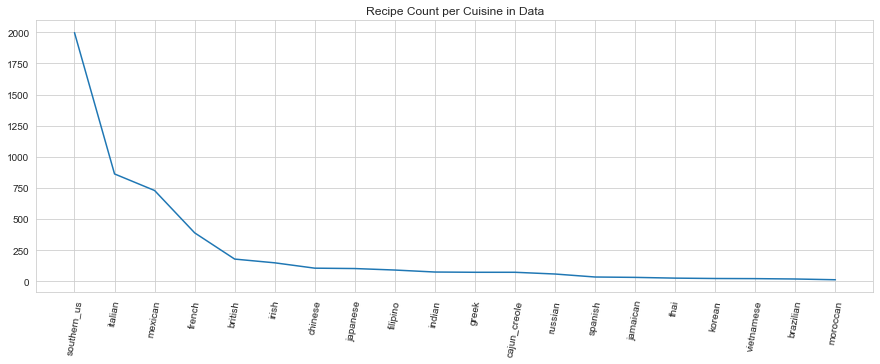

In [21]:
plt.figure(figsize=(15,5))
plt.title('Recipe Count per Cuisine in Data')
ax = df.cuisine.value_counts().plot()
plt.xticks(np.arange(len(df.cuisine.unique())), df.cuisine.value_counts().index, rotation=80)
plt.show()